# Домашнее задание 2 семинар

## Задача 1
Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;
- *преобразование данных transform

In [27]:
import torch
from torch import optim
import torch.nn.functional as F
from torch.nn import Linear, CrossEntropyLoss, Module, MaxPool2d, Conv2d
from torch.nn import Dropout2d, Dropout
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from termcolor import cprint


In [2]:

train_dataset = CIFAR10(root='./dataset10',
                        train=True,
                        transform=transforms.Compose(
                             [transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                        download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=4,
                                           shuffle=True)
test_dataset = CIFAR10(root='./dataset10', train=False,
                       download=True, transform=transforms.Compose(
                           [transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                          shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
image, label = train_dataset[50]
print(len(train_loader))
print(image.size())
print(label)


12500
torch.Size([3, 32, 32])
9


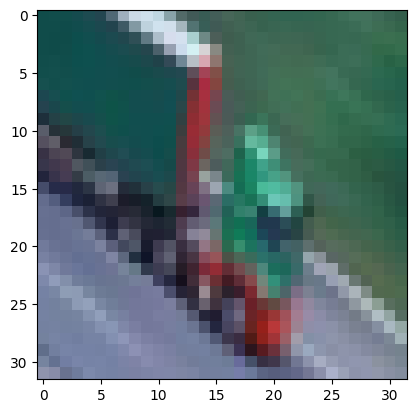

In [4]:
plt.imshow(image.permute(1, 2, 0).numpy())
plt.show()

In [5]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 6, 5)
        self.pool = MaxPool2d(2, 2)
        self.conv2 = Conv2d(6, 16, 5)
        self.fc1 = Linear(16 * 5 * 5, 120)
        self.fc2 = Linear(120, 84)
        self.fc3 = Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
net = Net().cuda()

In [16]:
net.train()
epochs = 20
criterion = CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in tqdm(range(epochs)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if not (i % 2000) and i != 0: 
            print(f'[{epoch + 1}, {(i + 1):5d}] loss: {(running_loss / 2000):.3f}')
            running_loss = 0.0

print('Training is finished!')

  0%|          | 0/10 [00:00<?, ?it/s]

[1,  2001] loss: 0.822
[1,  4001] loss: 0.841
[1,  6001] loss: 0.877
[1,  8001] loss: 0.892
[1, 10001] loss: 0.880
[1, 12001] loss: 0.907


 10%|█         | 1/10 [00:38<05:42, 38.08s/it]

[2,  2001] loss: 0.786
[2,  4001] loss: 0.827
[2,  6001] loss: 0.846
[2,  8001] loss: 0.853
[2, 10001] loss: 0.867
[2, 12001] loss: 0.893


 20%|██        | 2/10 [01:16<05:06, 38.32s/it]

[3,  2001] loss: 0.781
[3,  4001] loss: 0.786
[3,  6001] loss: 0.822
[3,  8001] loss: 0.856
[3, 10001] loss: 0.851
[3, 12001] loss: 0.841


 30%|███       | 3/10 [01:55<04:30, 38.60s/it]

[4,  2001] loss: 0.734
[4,  4001] loss: 0.770
[4,  6001] loss: 0.800
[4,  8001] loss: 0.808
[4, 10001] loss: 0.839
[4, 12001] loss: 0.858


 40%|████      | 4/10 [02:34<03:53, 38.92s/it]

[5,  2001] loss: 0.721
[5,  4001] loss: 0.772
[5,  6001] loss: 0.776
[5,  8001] loss: 0.793
[5, 10001] loss: 0.816
[5, 12001] loss: 0.820


 50%|█████     | 5/10 [03:14<03:16, 39.21s/it]

[6,  2001] loss: 0.693
[6,  4001] loss: 0.765
[6,  6001] loss: 0.746
[6,  8001] loss: 0.785
[6, 10001] loss: 0.801
[6, 12001] loss: 0.818


 60%|██████    | 6/10 [03:53<02:35, 38.99s/it]

[7,  2001] loss: 0.678
[7,  4001] loss: 0.727
[7,  6001] loss: 0.737
[7,  8001] loss: 0.763
[7, 10001] loss: 0.790
[7, 12001] loss: 0.799


 70%|███████   | 7/10 [04:31<01:56, 38.78s/it]

[8,  2001] loss: 0.648
[8,  4001] loss: 0.705
[8,  6001] loss: 0.749
[8,  8001] loss: 0.758
[8, 10001] loss: 0.749
[8, 12001] loss: 0.773


 80%|████████  | 8/10 [05:11<01:18, 39.02s/it]

[9,  2001] loss: 0.660
[9,  4001] loss: 0.698
[9,  6001] loss: 0.732
[9,  8001] loss: 0.755
[9, 10001] loss: 0.753
[9, 12001] loss: 0.785


 90%|█████████ | 9/10 [05:50<00:39, 39.06s/it]

[10,  2001] loss: 0.649
[10,  4001] loss: 0.678
[10,  6001] loss: 0.710
[10,  8001] loss: 0.727
[10, 10001] loss: 0.725
[10, 12001] loss: 0.775


100%|██████████| 10/10 [06:29<00:00, 38.95s/it]

Training is finished!


In [17]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [24]:
net.eval()
stop = 5
alls = (stop + 1) * 4
verifi = 0
print('Предсказано: | Реально:')
for k, data in enumerate(test_loader):
    inputs, labels = data[0].cuda(), data[1]
    pred = net(inputs).cpu()
    pred = pred.detach().numpy()
    labels = labels.numpy()
    for j, i in enumerate(pred):
        ind_p = np.argmax(i)
        ind_r = labels[j]
        if ind_p == ind_r:
            verifi += 1
        cprint(f'{classes[ind_p]:16s}{classes[ind_r]}', 'green' if ind_p == ind_r else 'red')
    if k == stop:
        break
cprint(f'Из {alls} угадано {verifi}. {verifi / alls * 100:3.2f}%', 'blue' )


Предсказано: | Реально:
cat             cat
ship            ship
ship            ship
plane           plane
frog            frog
frog            frog
car             car
frog            frog
cat             cat
car             car
plane           plane
truck           truck
cat             dog
horse           horse
truck           truck
ship            ship
dog             dog
cat             horse
ship            ship
frog            frog
horse           horse
plane           plane
bird            deer
truck           truck
Из 24 угадано 21. 87.50%


## Задача 2  

Переписать данный туториал на PyTorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

In [40]:
class MnistNet(Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.conv1 = Conv2d(1, 32, 3, 1)
        self.conv2 = Conv2d(32, 64, 3, 1)
        self.dropout1 = Dropout(0.25)
        self.dropout2 = Dropout(0.5)
        self.fc1 = Linear(9216, 128)
        self.fc2 = Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [41]:
img_rows = img_cols = 28
num_classes = 10
batch_size = 256
trn_data = MNIST(root = 'MNIST', train = True,
                           download = True, transform = transforms.ToTensor())
tst_data = MNIST(root = 'MNIST', train = False,
                           download = True, transform = transforms.ToTensor())
trn_loader = torch.utils.data.DataLoader(trn_data, batch_size = batch_size, shuffle = True)
tst_loader = torch.utils.data.DataLoader(tst_data, batch_size = batch_size, shuffle = True)


In [44]:
mnist = MnistNet().cuda()

In [45]:
net.train()
epochs = 20
optimizer = optim.Adadelta(net.parameters(), lr=0.001)
for epoch in tqdm(range(epochs)):  
    running_loss = 0.0
    for i, data in enumerate(trn_loader):
        inputs, labels = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()

        outputs = mnist(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if not (i % 2000) and i != 0: 
            print(f'[{epoch + 1}, {(i + 1):5d}] loss: {(running_loss / 2000):.3f}')
            running_loss = 0.0


100%|██████████| 20/20 [03:41<00:00, 11.09s/it]


In [46]:
mnist.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in tst_loader:
        data, target = data.cuda(), target.cuda()
        output = mnist(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(tst_loader.dataset)

print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(tst_loader.dataset)} ({100. * correct / len(tst_loader.dataset):.0f}%)\n')


Test set: Average loss: 2.3046, Accuracy: 990/10000 (10%)

